In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.4.1
Keras version: 2.4.0
Using Tesla V100-SXM2-32GB


In [3]:
# group images from /data/Thermal Camera Images by class into folders

classes = ["NoGas", "Perfume", "Smoke", "Mixture"]
IMAGE_LENGTH = 640
IMAGE_WIDTH = 480

REORGANIZE_DATA = False

if REORGANIZE_DATA:
    for c in classes:
        if not os.path.exists("data/Thermal Camera Images/" + c):
            os.makedirs("data/Thermal Camera Images/" + c)

    # move images into folders
    # images follow the pattern: "#_class.png"

    # get all .png files in the directory
    files = os.listdir("data/Thermal Camera Images")
    png_files = [f for f in files if f.endswith(".png")]

    # move images into folders
    for f in png_files:
        # get the class of the image
        class_name = f.split("_")[1]
        # remove the .png extension
        class_name = class_name.split(".")[0]
        # move the image into the corresponding folder
        os.rename("data/Thermal Camera Images/" + f, "data/Thermal Camera Images/" + class_name + "/" + f)
        
# function that plots model history
def plot_history(history, name):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy %')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')

    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)

    plt.show()

In [4]:
class MultimodalDataset():
    def __init__(self, data, use_sensors=True, use_images=True):
        # filepaths = data['filepath']
        self.images = data['filepath'].values
        # MQ2 MQ3 MQ5 MQ6 MQ7 MQ8 MQ135
        self.sensor_data = data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']].values
        # Gas values
        self.classes = data['Gas'].values
        # if the number of unique classes is not 4, change some
        # this ensure that the dataset return the right sizes even if only a segment of the data is used by lying
        if len(np.unique(self.classes)) != 4:
            self.classes[0] = "Smoke"
            self.classes[1] = "Perfume"
            self.classes[2] = "Mixture"
            self.classes[3] = "NoGas"

        # Gas one-hot encoded
        cat = OneHotEncoder()
        self.labels = cat.fit_transform(self.classes.reshape(-1, 1)).toarray()
        self.use_sensors = use_sensors
        self.use_images = use_images

        if not use_sensors and not use_images:
            raise ValueError("Both use_sensors and use_images cannot be False")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.use_images:
            filepath = self.images[idx]
            image = tf.io.read_file(filepath)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            
            # normalize image
            image = image / 255.0

        sensor_data = self.sensor_data[idx]
        label = self.labels[idx]
        
        if self.use_sensors and self.use_images:
            return image, sensor_data, label
        elif self.use_sensors:
            return sensor_data, label
        elif self.use_images:
            return image, label
        
    def __call__(self):
        if self.use_sensors and self.use_images:
            for i in range(self.__len__()):
                # packacge both sensor data and image together
                output = self.__getitem__(i)
                yield {"image": output[0], "sensor": output[1]}, output[2]
        
        else:
            for i in range(self.__len__()):
                yield self.__getitem__(i)
        
    def get_path(self, idx):
        return self.images[idx]

In [5]:
# load sensor data from data/Gas Sensors Measurements/Gas_Sensor_Measurements.csv
file_data = pd.read_csv("data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")

# rename Corrosponding Image Name to filename
file_data = file_data.rename(columns={"Corresponding Image Name": "filepath"})

# get a numeric representation of the gas
file_data["Gas_id"] = file_data["Gas"].apply(lambda x: classes.index(x))

# change the image names from "#_class" to "/data/Thermal Camera Images/class/#_class.png"
file_data["filepath"] = file_data["filepath"].apply(lambda x: "data/Thermal Camera Images/" + x.split("_")[1] + "/" + x + ".png")

# set Serial Number to Serial Number + (Gas_id * 1600)
# this geives every line a unique id
file_data["Serial Number"] = file_data["Serial Number"] + (file_data["Gas_id"] * 1600)

# extract Serial Number and Gas as numpy arrays
split_data = file_data[["Serial Number", "Gas_id"]].to_numpy()

# print total number of samples
print(f'Total number of samples: {len(file_data)}')

# print the number of samples in each class
print("Number of samples in each class:")
print(file_data["Gas_id"].value_counts())

# perfom a test train split and stratify by gas
train_idx, test_idx = train_test_split(split_data, test_size=0.2, stratify=split_data[:, 1], random_state=13)

# print length of train and test sets
print("Train set size:", len(train_idx))
print("Test set size:", len(test_idx))

# get the index of the train and test data
train_idx = train_idx[:, 0]
test_idx = test_idx[:, 0]

# create empty dataframes to store the train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for i in train_idx:
    train_data = pd.concat([train_data, file_data[file_data["Serial Number"] == i]])

for i in test_idx:
    test_data = pd.concat([test_data, file_data[file_data["Serial Number"] == i]])

test_data.head()

Total number of samples: 6400
Number of samples in each class:
0    1600
1    1600
2    1600
3    1600
Name: Gas_id, dtype: int64
Train set size: 5120
Test set size: 1280


,Serial Number,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas,filepath,Gas_id
3572,3572,571,351,339,376,570,564,284,Smoke,data/Thermal Camera Images/Smoke/372_Smoke.png,2
1530,1530,758,533,402,397,538,574,508,NoGas,data/Thermal Camera Images/NoGas/1530_NoGas.png,0
531,531,734,530,397,396,597,587,442,NoGas,data/Thermal Camera Images/NoGas/531_NoGas.png,0
5704,5704,663,416,457,431,540,508,455,Mixture,data/Thermal Camera Images/Mixture/904_Mixture...,3
6071,6071,587,439,411,379,432,335,423,Mixture,data/Thermal Camera Images/Mixture/1271_Mixtur...,3


In [6]:
# apply a standard scaler to the sensor data
scaler = StandardScaler()
train_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']] = scaler.fit_transform(train_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']])
test_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']] = scaler.transform(test_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']])

Image shape: (640, 480, 3)


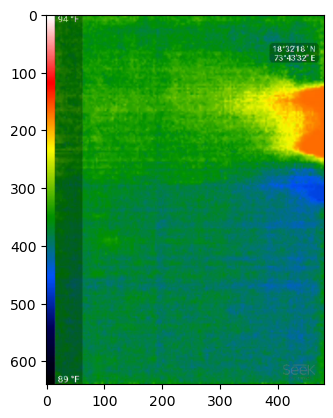

In [7]:
import matplotlib.pyplot as plt
img_path = 'data/Thermal Camera Images/Smoke/1_Smoke.png'

# load image
image = tf.io.read_file(img_path)
image = tf.image.decode_png(image, channels=3)

print(f'Image shape: {image.shape}')

# display image
plt.imshow(image)
plt.show()

In [8]:
image_gen = MultimodalDataset(train_data, use_sensors=False, use_images=True)
image_dataset = tf.data.Dataset.from_generator(
    image_gen,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

image_dataset = image_dataset.batch(128)
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)
image_dataset = image_dataset.cache()

val_image_gen = MultimodalDataset(test_data, use_sensors=False, use_images=True)
val_image_dataset = tf.data.Dataset.from_generator(
    val_image_gen,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

val_image_dataset = val_image_dataset.batch(128)
val_image_dataset = val_image_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_image_dataset = val_image_dataset.cache()

In [9]:
# create a simple CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 638, 478, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 319, 239, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 317, 237, 64)      18496     
_________________________________________________________________
dropout (Dropout)            (None, 317, 237, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 158, 118, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 156, 116, 128)     73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 156, 116, 128)     0

In [10]:
history = model.fit(image_dataset, validation_data=val_image_dataset, epochs=30, verbose=1)

Epoch 1/40
40/40 [==============================] - 119s 3s/step - loss: 1.3836 - accuracy: 0.2759 - val_loss: 1.3472 - val_accuracy: 0.4727
Epoch 2/40
40/40 [==============================] - 23s 576ms/step - loss: 1.3037 - accuracy: 0.4221 - val_loss: 1.2394 - val_accuracy: 0.5375
Epoch 3/40
40/40 [==============================] - 23s 576ms/step - loss: 1.1582 - accuracy: 0.5178 - val_loss: 1.1197 - val_accuracy: 0.5844
Epoch 4/40
40/40 [==============================] - 23s 577ms/step - loss: 0.9287 - accuracy: 0.6274 - val_loss: 0.9179 - val_accuracy: 0.6922
Epoch 5/40
40/40 [==============================] - 23s 576ms/step - loss: 0.7500 - accuracy: 0.6978 - val_loss: 0.7532 - val_accuracy: 0.7750
Epoch 6/40
40/40 [==============================] - 23s 577ms/step - loss: 0.5975 - accuracy: 0.7630 - val_loss: 0.6790 - val_accuracy: 0.7766
Epoch 7/40
40/40 [==============================] - 23s 577ms/step - loss: 0.5173 - accuracy: 0.7906 - val_loss: 0.5998 - val_accuracy: 0.7977
E

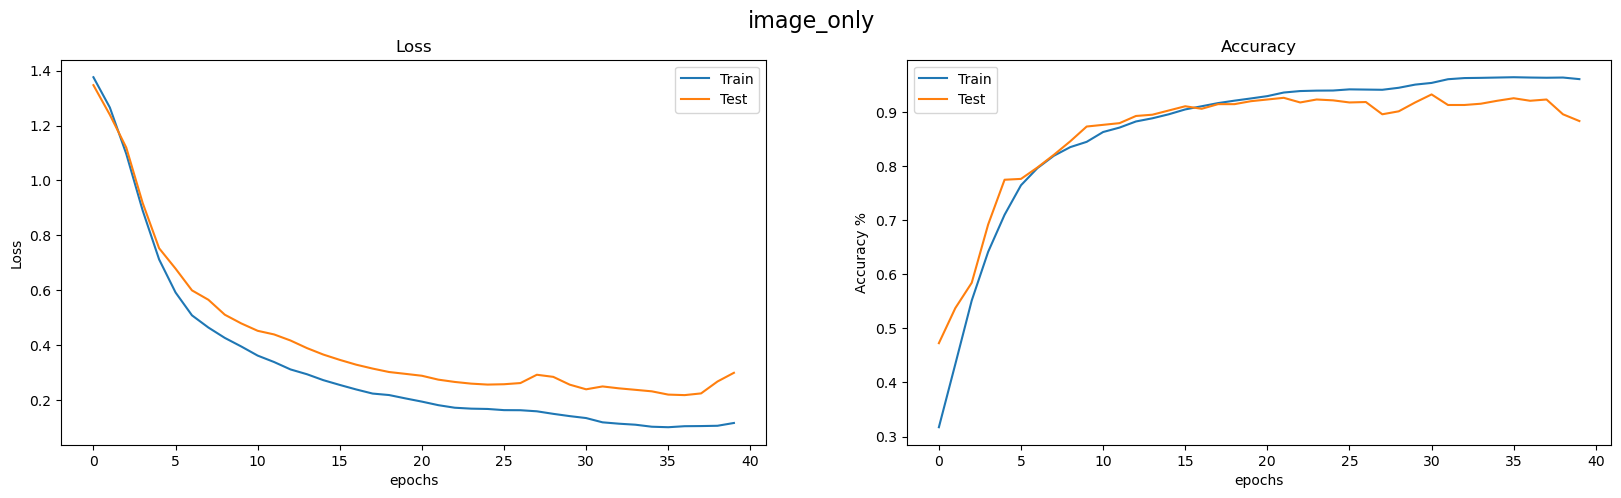

In [11]:
plot_history(history, "image_only")

In [12]:
sensor_gen = MultimodalDataset(train_data, use_sensors=True, use_images=False)
sensor_dataset = tf.data.Dataset.from_generator(
    sensor_gen,
    output_signature=(
        tf.TensorSpec(shape=(7,), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

sensor_dataset = sensor_dataset.batch(128)
sensor_dataset = sensor_dataset.prefetch(tf.data.AUTOTUNE)
sensor_dataset = sensor_dataset.cache()

val_sensor_gen = MultimodalDataset(test_data, use_sensors=True, use_images=False)
val_sensor_dataset = tf.data.Dataset.from_generator(
    val_sensor_gen,
    output_signature=(
        tf.TensorSpec(shape=(7,), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

val_sensor_dataset = val_sensor_dataset.batch(64)
val_sensor_dataset = val_sensor_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_sensor_dataset = val_sensor_dataset.cache()

In [13]:
# create a simple MLP
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total params: 6,884
Trainable params: 6,884
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(sensor_dataset, validation_data=val_sensor_dataset, epochs=30, verbose=1)

Epoch 1/40
40/40 [==============================] - 1s 15ms/step - loss: 1.3750 - accuracy: 0.2869 - val_loss: 1.2741 - val_accuracy: 0.4641
Epoch 2/40
40/40 [==============================] - 0s 4ms/step - loss: 1.2408 - accuracy: 0.5823 - val_loss: 1.1396 - val_accuracy: 0.7570
Epoch 3/40
40/40 [==============================] - 0s 5ms/step - loss: 1.1041 - accuracy: 0.7744 - val_loss: 1.0077 - val_accuracy: 0.7844
Epoch 4/40
40/40 [==============================] - 0s 3ms/step - loss: 0.9718 - accuracy: 0.7880 - val_loss: 0.8778 - val_accuracy: 0.8109
Epoch 5/40
40/40 [==============================] - 0s 3ms/step - loss: 0.8414 - accuracy: 0.8229 - val_loss: 0.7430 - val_accuracy: 0.8414
Epoch 6/40
40/40 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.8514 - val_loss: 0.6253 - val_accuracy: 0.8594
Epoch 7/40
40/40 [==============================] - 0s 3ms/step - loss: 0.5988 - accuracy: 0.8566 - val_loss: 0.5379 - val_accuracy: 0.8664
Epoch 8/40
40/40 [=

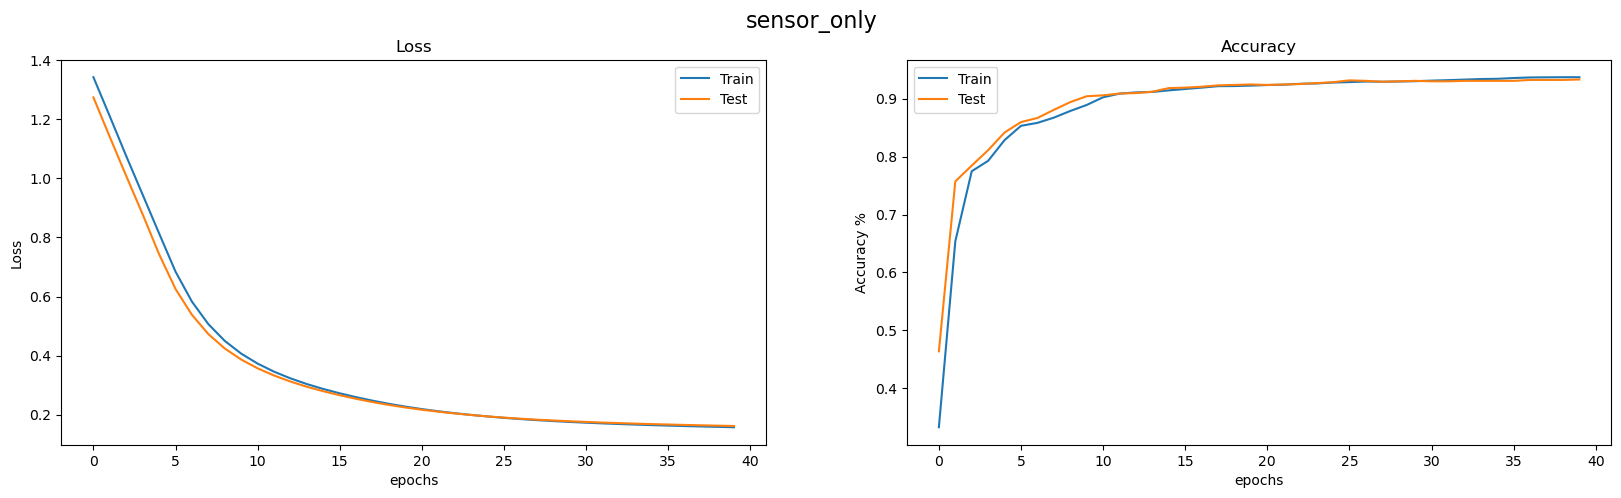

In [15]:
plot_history(history, "sensor_only")

In [16]:
multimodal_gen = MultimodalDataset(train_data, use_sensors=True, use_images=True)
multimodal_dataset = tf.data.Dataset.from_generator(
    multimodal_gen,
    output_signature=(
        {
            'image': tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
            'sensor': tf.TensorSpec(shape=(7,), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

multimodal_dataset = multimodal_dataset.batch(128)
multimodal_dataset = multimodal_dataset.prefetch(tf.data.AUTOTUNE)
multimodal_dataset = multimodal_dataset.cache()

val_multimodal_gen = MultimodalDataset(test_data, use_sensors=True, use_images=True)
val_multimodal_dataset = tf.data.Dataset.from_generator(
    val_multimodal_gen,
    output_signature=(
        {
            'image': tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
            'sensor': tf.TensorSpec(shape=(7,), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

val_multimodal_dataset = val_multimodal_dataset.batch(128)
val_multimodal_dataset = val_multimodal_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_multimodal_dataset = val_multimodal_dataset.cache()

In [17]:
# create a functional multimodal CNN
image_input = tf.keras.Input(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), name='image')
sensor_input = tf.keras.Input(shape=(7,), name='sensor')

image = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Flatten()(image)
image = tf.keras.layers.Dense(512, activation='relu')(image)
image = tf.keras.layers.Dense(64, activation='relu')(image)

sensor = tf.keras.layers.Dense(32, activation='relu')(sensor_input)
sensor = tf.keras.layers.Dense(32, activation='relu')(sensor)
sensor = tf.keras.layers.Dense(16, activation='relu')(sensor)

concat = tf.keras.layers.concatenate([image, sensor])
dense = tf.keras.layers.Dense(32, activation='relu')(concat)
output = tf.keras.layers.Dense(4, activation='softmax')(dense)

model = tf.keras.Model(inputs=[image_input, sensor_input], outputs=output)

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 640, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 638, 478, 32) 896         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 319, 239, 32) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 317, 237, 64) 18496       max_pooling2d_6[0][0]            
______________________________________________________________________________________________

In [ ]:
history = model.fit(multimodal_dataset, validation_data=val_multimodal_dataset, epochs=25, verbose=1)

Epoch 1/25
40/40 [==============================] - 109s 3s/step - loss: 1.4464 - accuracy: 0.2434 - val_loss: 1.3651 - val_accuracy: 0.4086
Epoch 2/25
40/40 [==============================] - 23s 574ms/step - loss: 1.3486 - accuracy: 0.4405 - val_loss: 1.3211 - val_accuracy: 0.4125
Epoch 3/25
40/40 [==============================] - 23s 573ms/step - loss: 1.3067 - accuracy: 0.5360 - val_loss: 1.2829 - val_accuracy: 0.5156
Epoch 4/25
33/40 [=======================>......] - ETA: 3s - loss: 1.2595 - accuracy: 0.5719

In [ ]:
plot_history(history, "multimodal")